In [551]:
# imports
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import pickle

In [2]:
df_data= pd.read_csv('lemonade_ds_coding_task_data_(2).csv')
df_data.head()

,id,state,postal_code,product,user_id,square_ft,high_risk_dog,has_fire_alarm,has_burglar_alarm,portable_electronics,coast,fire_housing_proximity,previous_policies,user_age,card_type,target
0,2492008697672104938,NM,87043,ho4,-9160046293075786063,NaN,0,True,True,0.0,NaN,5,0,39.0,credit,False
1,886075317023782670,WI,53715,ho4,-8929003830875133003,NaN,0,True,False,1.0,30.0,1,0,19.0,debit,False
2,5527292118261850881,WI,53211,ho4,-9015977226434470133,NaN,0,True,False,1.0,1.0,1,0,20.0,debit,True
3,6453397743269682220,NM,88012,ho4,-9060026899039337265,NaN,0,True,True,1.0,NaN,1,0,33.0,debit,False
4,-8836394806705049849,AR,72116,ho4,-8801719090048493625,NaN,0,False,False,1.0,NaN,1,0,20.0,debit,False


To Avoid data leakage we'll **split the df to train-validation-test**:
- marking each index tr/val/ts
- Exploration & feature engineering based on tr rows 
- training model on tr-val, final model varified with ts

In [3]:
split_idx= np.random.choice(range(3),len(df_data),p=[0.75,0.15,0.1])
df_data['df_type']=np.where(split_idx==0,'tr',np.where(split_idx==1,'val','ts'))

df_data.df_type.value_counts(normalize=True)

tr     0.753489
val    0.152779
ts     0.093732
Name: df_type, dtype: float64

## data processing & exploration

In [4]:
df= df_data.loc[df_data.df_type=='tr'] #train df for exploration & feature engineering ref. 
df['user_age_gr']= df.user_age.dropna().apply(lambda x: int(math.ceil(x/10))*10)

### some exploration to "feel" the data

In [5]:
display(df.target.value_counts(normalize=True))
print('Our labels are very imbalanced')

False    0.976662
True     0.023338
Name: target, dtype: float64

Our labels are very imbalanced


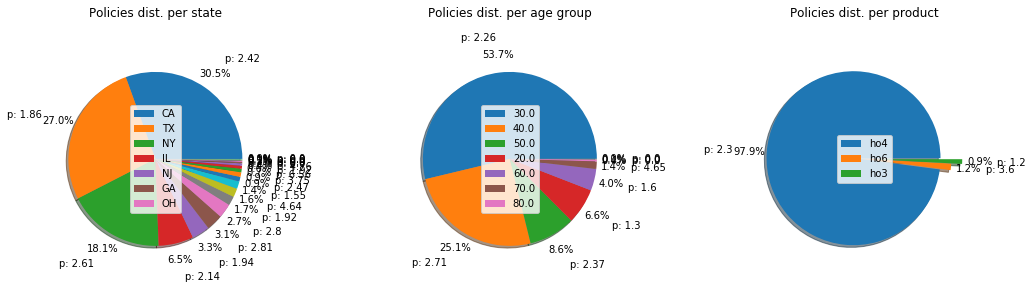

In [6]:
# proportion of things: % of product policies , % of state + claim % annotate , % by age group

fig, ax= plt.subplots(1,3, figsize=(18,5))

ax[0].pie(df['state'].value_counts(),
        labels=['p: '+str(e) for e in (df.groupby('state').target.mean().loc[df['state'].value_counts().index]*100).round(2)],
        autopct='%1.1f%%', shadow=True,  pctdistance=1.2, labeldistance=1.4,  radius=0.8)
ax[0].legend(labels= df['state'].value_counts().head(7).index, loc="center")
# change the legend to be with the values
ax[0].set_title('Policies dist. per state')

ax[1].pie(df['user_age_gr'].value_counts(),
        labels=['p: '+str(e) for e in (df.groupby('user_age_gr').target.mean().loc[df['user_age_gr'].value_counts().index]*100).round(2)],
        autopct='%1.1f%%', shadow=True,  pctdistance=1.2, labeldistance=1.4,  radius=0.8)
ax[1].legend(labels= df['user_age_gr'].value_counts().head(7).index, loc="center")
ax[1].set_title('Policies dist. per age group')

ax[2].pie(df['product'].value_counts(),
        labels=['p: '+str(e) for e in (df.groupby('product').target.mean().loc[df['product'].value_counts().index]*100).round(1)],
        explode= [.1,0,.1],autopct='%1.1f%%', shadow=True,  pctdistance=1.2, labeldistance=1.4,  radius=0.8)
ax[2].legend(labels= df['product'].value_counts().index, loc="center")
ax[2].set_title('Policies dist. per product');



> - Product type: vast majority of the policies are of ho6 with claim prob of 2.2% 
- users ages: most of the policy purchasers are 30-50. more than 50% of the users are in their 30s, with 2.15% chance of claim, while the 25% of users in their 40s have 2.7% chance of claim. 

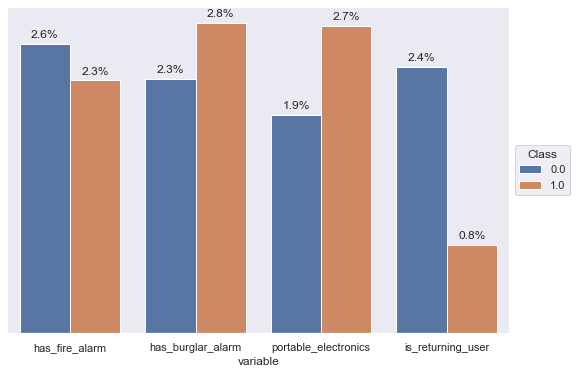

In [655]:
p_df= pd.concat([df.groupby('has_fire_alarm').target.mean().reset_index().melt(id_vars='target'),
           df.groupby('has_burglar_alarm').target.mean().reset_index().melt(id_vars='target'),
           df.groupby('portable_electronics').target.mean().reset_index().melt(id_vars='target'),
           df.assign(is_returning_user= df.previous_policies>1).groupby('is_returning_user').target.mean().reset_index().melt(id_vars='target')])

g= sns.barplot(x='variable',y='target',hue='value',data=p_df)

for p in g.patches: 
    g.annotate(format(p.get_height(),'.1%'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 9), 
                   textcoords='offset points')
g.axes.get_yaxis().set_visible(False)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5),title='Class');

> - Having portable electorincs seems to increase claim prob (2.7% vs 1.9%)
- New users have more claims relativly to a returning user with past policies. this is interesting, could suggest fraud (otherwise why would i.e 2nd time policy have less prob than 1st time policy?)
- it's interesting that there are more burglaries (and claims) when there is a burglary alarm. could suggest high burglary areas will have a burglary alarm, more than the alarm scarying off the burglers...

### missing values

In [9]:
display(df.isna().mean().sort_values(ascending=False).to_frame().T)
print(f'we have {sum(df.isna().mean()>0)} features with missing values. lets examine how to handle each')

,square_ft,coast,portable_electronics,user_age_gr,user_age,card_type,high_risk_dog,state,postal_code,product,user_id,has_burglar_alarm,has_fire_alarm,df_type,fire_housing_proximity,previous_policies,target,id
0,0.978696,0.092281,0.03308,0.006316,0.006316,0.004175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


we have 6 features with missing values. lets examine how to handle each


In [10]:
# coast distance 
# first lets see per state where we have missing coast dist values 
states_is_coast= df.groupby(['state',df.coast.isna()]).size().unstack().fillna(0)\
.apply(lambda x: x.div(x.sum()),axis=1)

# seems like most states either should have coast distance value or they don't . lets classify them by % of records. 
states_is_coast= states_is_coast.assign(is_coast_state= lambda x: np.where(x[True]==1, 0, np.where(x[False]==1, 1, np.where(x[False]<.1,0,1))))
display(states_is_coast)

coast_state_dict= states_is_coast.is_coast_state.to_dict()

coast,False,True,is_coast_state
state,,,
AR,0.000000,1.000000,0
AZ,0.000000,1.000000,0
CA,1.000000,0.000000,1
CT,1.000000,0.000000,1
DC,0.019231,0.980769,0
GA,1.000000,0.000000,1
IA,0.000000,1.000000,0
IL,1.000000,0.000000,1
IN,1.000000,0.000000,1


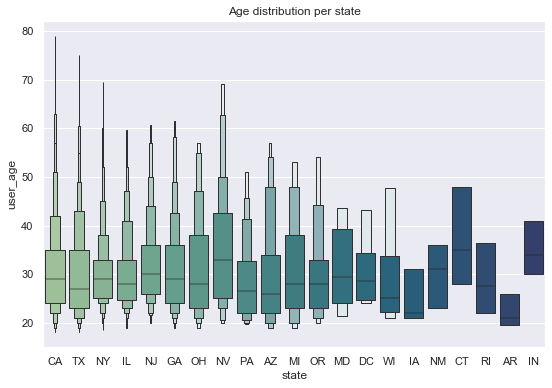

,CA,TX,NY,IL,NJ,GA,OH,NV,PA,AZ,...,OR,MD,DC,WI,IA,NM,CT,RI,AR,IN
state,0.305214,0.270207,0.180602,0.064982,0.03308,0.030511,0.026764,0.016701,0.016165,0.01381,...,0.008564,0.00653,0.005567,0.004496,0.002355,0.00182,0.001606,0.001285,0.000749,0.000321


We can see for the larger states in the ds, the age distribution is not very different . 
for example NV is 1.7% of the records. this leads me to complete age values by overall average (and not by state)

Overall stats for user age - a bit shifted right (mean>median): 


,count,mean,std,min,25%,50%,75%,max
user_age,9282.0,31.016591,10.008182,18.0,24.0,28.0,35.0,99.0


Completing Nan age values with 31


In [11]:
# user age 
sns.set(rc={'figure.figsize':(9,6)})
df.groupby('state').user_age.mean()
sns.boxenplot(x='state',y='user_age',data=df, palette='crest', 
              order= df.state.value_counts().index.tolist(), showfliers=False);
plt.title('Age distribution per state')
plt.show()
display(df.state.value_counts(normalize=True).to_frame().T)

print("""We can see for the larger states in the ds, the age distribution is not very different . 
for example NV is 1.7% of the records. this leads me to complete age values by overall average (and not by state)""")

print('\nOverall stats for user age - a bit shifted right (mean>median): ')
display(df.user_age.describe().to_frame().T)

age_fill_val= int(df.user_age.mean())
print(f'Completing Nan age values with {age_fill_val}')

In [12]:
# card type proportions
df.card_type.value_counts(normalize=True)

debit      0.585143
credit     0.399914
prepaid    0.014943
Name: card_type, dtype: float64

> **Missing values analysis summary:**
1. `square_ft` - has 97% missing records. there's not much to do with this no-information feature, so we'll drop the column all together. on the intuition level doesn't seem to predictive to claim or not (not much variance in house sized) so the 3% won't contribute too much.
1. `coast` - distance from coast. this is for states with a coast line (i.e CA) . i've decided states with less than 10% of records having coast distance,  will be classified as no-coast state. for the no coast state, we'll place 999 as value
1. `portable_electronics` - we'll fill missing values with 0 (as no electronics) 
1. `user_age` - we'll fill missing values with the overall average user age as we saw there's no much differance across states
1. `card_type` - i'll complete the missing values with `unknown` additional category, as the dataset is about 50:50 between credit and debit

In [13]:
# complete missing values - on full dataset (based on train results)
df_data['is_coast_country']= df_data.state.map(coast_state_dict)
df_data['coast_f']= np.where(df_data.is_coast_country==1, df_data.coast, 999)

df_data['portable_electronics']= df_data.portable_electronics.fillna(0)
df_data['user_age']= df_data.user_age.fillna(age_fill_val)
df_data['card_type']= df_data.card_type.fillna('unknown')

### Categorical features

algorithms know to work with binary/numeric data. for the categorical features we'll need to either do one-hot-encoding ('spread' the categories to 1/0) or for ordinal features encode with int.

- I am contemplating if for state I should use OHE (multiple binary columns can also lose their effect) or to code them with int range although there's no ordianl logic. i'll check both options

In [14]:
# our categorical features
print('Our categorical features are:', df_data.select_dtypes(include='object').columns.tolist())

# checking firehousing :
df.fire_housing_proximity.value_counts()
print("seems like firehousing proximity means number of firehouses around the rental. so we'll make this an int as it should be")

df_data['fire_housing_proximity']= df_data.fire_housing_proximity.apply(lambda x: x if x.isdigit() else
                                                              ''.join(c for c in x if c.isdigit()) ).astype(int)

print('after fixing fire_housing:', df_data.select_dtypes(include='object').columns.tolist())

Our categorical features are: ['state', 'product', 'fire_housing_proximity', 'card_type', 'df_type']
seems like firehousing proximity means number of firehouses around the rental. so we'll make this an int as it should be
after fixing fire_housing: ['state', 'product', 'card_type', 'df_type']


**State to integer**: since there are a lot of states, i wouldn't want to create so many dummies. coding to an int variable although there's no ordianl logic here, is pretty random, so i'll rank the states by size, and that will be their codes. that will encorporating some 'magniture' value, their weight, thus ordinality

In [15]:
# states to int 
state_int_dict= {s:i for i,s in enumerate(df.state.value_counts().index.tolist())} #based on train states - luckily no missing states
df_data['state_int']= df_data.state.map(state_int_dict)

# since i'm not sure (and intrigued) i'll also create OHE from country
state_ohe= pd.get_dummies(df_data.state,prefix='state_')

In [16]:
# categorical to OHI
card_ohe= pd.get_dummies(df_data.card_type,prefix='card_')
product_ohe= pd.get_dummies(df_data['product'],prefix='product_')

df_ohe= pd.concat([card_ohe, product_ohe, state_ohe],axis=1)

### additional Feature engineering

In [17]:
#is returning user 
df_data['is_returning_user']= df_data.previous_policies>1

## Fitting a model

In [18]:
print(df.target.value_counts(normalize=True))

print(f"There's {round(df.target.value_counts(normalize=True)[True]*100,1)}% chance for a claim. as we saw earlier, very imbalanced 0/1 labels")

False    0.976662
True     0.023338
Name: target, dtype: float64
There's 2.3% chance for a claim. as we saw earlier, very imbalanced 0/1 labels


> **Model Evaluation**: For an imbalanced ds we don't want to use accuracy to evaluate the model . 
- i.e we can have very high accuracy score, but it represents mostly the prediction accuracy of 0 , and very lously for 1

- Precision: the % of records identified correctly as positive out of all identified positives TP/(TP+FP).it measures the probability of detection of true value out of predicted true . the % of actually true in the prediciton.
- **Recall**: summarizes how well the positive class was predicted. Identify correctly the trues : TP/ (TP+FN). it's ability to find all the true labels
- when the FP cost is more expensive, we want to track precision. but i would think in our case FN is more expensive as we don't want to miss predicting a claim.so we want Recall as high as possible.  
- While recall expresses the ability to find all relevant instances in a dataset, precision expresses the proportion of the data points our model says was relevant actually were relevant. we don't want FP to explode but we can have it high (prec. low) 

- we will use **PR curve and AUC** . The focus of the PR curve on the minority class makes it an effective diagnostic for imbalanced binary classification models
    - PR AUC to compare models
    - PR curve to determined the TH for the selected model to predict 1/0


### setting train-val-test dfs

In [445]:
modeling_features_ex_ct= ['state_int','postal_code', 'is_coast_country', 'coast_f',
'high_risk_dog', 'has_fire_alarm', 'has_burglar_alarm', 'fire_housing_proximity',
'portable_electronics','previous_policies','user_age', 'is_returning_user' ]

print('we drop from X:',[f for f in df_data.select_dtypes(exclude='object').columns if f not in modeling_features_ex_ct])

df_train= df_data.loc[df_data.df_type=='tr',modeling_features_ex_ct+['target']].join(df_ohe)
x_train,y_train = df_train.drop('target',axis=1), df_train.target

df_val= df_data.loc[df_data.df_type=='val',modeling_features_ex_ct+['target']].join(df_ohe)
x_val,y_val = df_val.drop('target',axis=1), df_val.target

df_test= df_data.loc[df_data.df_type=='ts',modeling_features_ex_ct+['target']].join(df_ohe)
x_test,y_test = df_test.drop('target',axis=1), df_test.target

we drop from X: ['id', 'user_id', 'square_ft', 'coast', 'target']


In [1]:
150/32


4.6875

### Fitting models

In [21]:
from sklearn import metrics

In [122]:
from sklearn.linear_model import LogisticRegression 

lr = LogisticRegression()
lr.fit(x_train,y_train)
lr_y_pred = lr.predict(x_val)

precision, recall, _ = metrics.precision_recall_curve(y_val, lr.predict_proba(x_val)[:, 1])
lr_auc = metrics.auc(recall, precision)
# lr_mcc= metrics.matthews_corrcoef(y_val, lr_y_pred)

print(f'LogisticRegression  - PR AUC: {round(lr_auc,3)}')

LogisticRegression  - PR AUC: 0.018


In [446]:
# check the OHE and not -- the same 
x_train_n_s_ohe= x_train.drop([sc for sc in df_ohe.columns if sc.startswith('state')],axis=1)
x_val_n_s_ohe= x_val.drop([sc for sc in df_ohe.columns if sc.startswith('state')],axis=1)

lr.fit(x_train_n_s_ohe,y_train)
lr1_y_pred = lr.predict(x_val_n_s_ohe)

precision, recall, _ = metrics.precision_recall_curve(y_val, lr.predict_proba(x_val_n_s_ohe)[:, 1])
lr1_auc = metrics.auc(recall, precision)
# lr1_mcc= metrics.matthews_corrcoef(y_val, lr1_y_pred)

print(f'LogisticRegression- no ohe  - PR AUC: {round(lr1_auc,3)}')

LogisticRegression- no ohe  - PR AUC: 0.018


> no difference when using ohe, so dropping this direction. not sure if logistic regression is the model to see such difference, but anyways, i'll keep working with the dummies

In [124]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(x_train,y_train)
nb_y_pred = nb.predict(x_val)

precision, recall, _ = metrics.precision_recall_curve(y_val, nb.predict_proba(x_val)[:, 1])
nb_auc = metrics.auc(recall, precision)
# nb_mcc= metrics.matthews_corrcoef(y_val, nb_y_pred)

print(f'NaiveBayes  - PR AUC: {round(nb_auc,3)}; ')

NaiveBayes  - PR AUC: 0.021; 


In [125]:
import xgboost

xgb= xgboost.XGBClassifier(random_state=123)
xgb.fit(x_train,y_train)
xgb_y_pred = xgb.predict(x_val)

precision, recall, _ = metrics.precision_recall_curve(y_val, xgb.predict_proba(x_val)[:, 1])
xgb_auc = metrics.auc(recall, precision)
# xgb_mcc= metrics.matthews_corrcoef(y_val, xgb_y_pred)

print(f'XGBoost:   - PR AUC: {round(xgb_auc,3)}; ')

XGBoost:   - PR AUC: 0.027; 


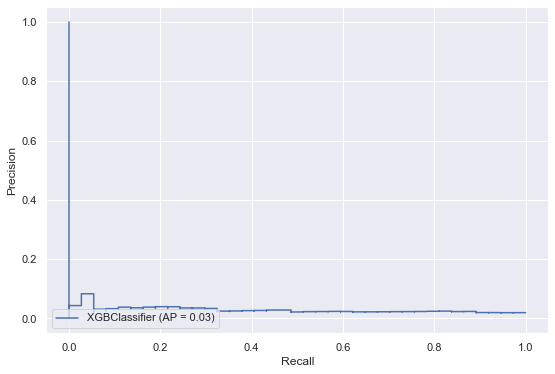

In [126]:
metrics.plot_precision_recall_curve(xgb, x_val, y_val)

In [488]:
# lets see if catboost with its categorical features handling does better job than xgb w OHE
from catboost import CatBoostClassifier

x_tr_n_ohe= x_train_n_s_ohe.drop([c for c in x_train_n_s_ohe.columns if 
                                  (c.startswith('product') or c.startswith('card'))],axis=1).join(df_data[['product','state','card_type']])
x_val_n_ohe= x_val_n_s_ohe.drop([c for c in x_val_n_s_ohe.columns if (c.startswith('product') or c.startswith('card'))],axis=1).join(df_data[['product','state','card_type']])


ctb = CatBoostClassifier(random_seed=123,silent=True)
ctb.fit(x_tr_n_ohe, y_train,
        cat_features=range(x_tr_n_ohe.shape[1]-3,x_tr_n_ohe.shape[1]))

ctb_y_pred = ctb.predict(x_val_n_ohe)

precision, recall, _ = metrics.precision_recall_curve(y_val, ctb.predict_proba(x_val_n_ohe)[:, 1])
ctb_auc = metrics.auc(recall, precision)
# ctb_mcc= metrics.matthews_corrcoef(y_val, ctb_y_pred.astype('bool'))

print(f'CatBoost:   - PR AUC: {round(ctb_auc,3)}; ')

CatBoost:   - PR AUC: 0.035; 


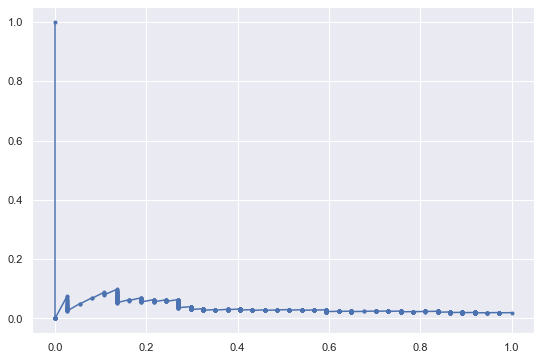

In [464]:
plt.plot(recall, precision, marker='.', label='CatBoost')

so catboost with it's categorical handeling did a better job than xgboost with our cat handeling

In [217]:
from sklearn.tree import DecisionTreeClassifier

cart = DecisionTreeClassifier(random_state=123)
cart.fit(x_train,y_train)
cart_y_pred = cart.predict(x_val)

precision, recall, _ = metrics.precision_recall_curve(y_val, cart.predict_proba(x_val)[:, 1])
cart_auc = metrics.auc(recall, precision)
# cart_mcc= metrics.matthews_corrcoef(y_val, cart_y_pred)

print(f'DecisionTree: PR AUC: {round(cart_auc,3)}; ')

DecisionTree: PR AUC: 0.043; 


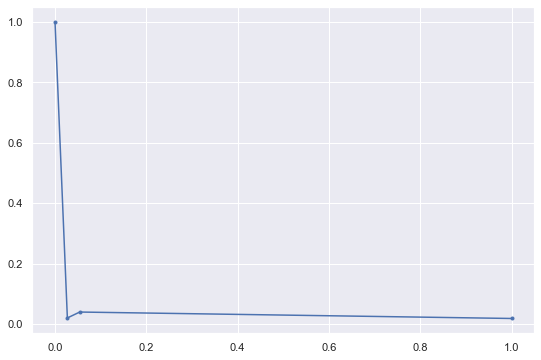

In [219]:
plt.plot(recall, precision, marker='.', label='cart')

In [220]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 1000,random_state = 123)
rf.fit(x_train,y_train)
rf_y_pred = rf.predict(x_val)

precision, recall, _ = metrics.precision_recall_curve(y_val, rf.predict_proba(x_val)[:, 1])
rf_auc = metrics.auc(recall, precision)
# rf_mcc= metrics.matthews_corrcoef(y_val, rf_y_pred)

print(f"RandomForest: PR AUC: {round(rf_auc,3)}; ")

RandomForest: PR AUC: 0.024; 


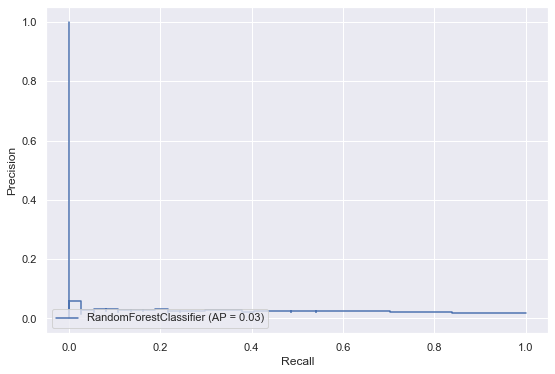

In [141]:
metrics.plot_precision_recall_curve(rf, x_val, y_val);

In [143]:
from sklearn.svm import SVC 

svm = SVC(kernel='sigmoid') 
svm.fit(x_train, y_train) 
svm_y_pred = svm.predict(x_val)       # Predict using classifier TH.

svm_predict_proba= svm.decision_function(x_val) # svm doesn't have predict_proba. using descision_function instead 

precision, recall, _ = metrics.precision_recall_curve(y_val, svm_predict_proba) 
svm_auc = metrics.auc(recall, precision)

print(f"SVM: PR AUC: {round(svm_auc,3)}; ")

SVM: PR AUC: 0.03; 


**Model fitting sumaary**
> - lets stop here. the best peforming model in terms of PR-AUC is **DecisionTree** classifier
- the simple LogisticRegression and NB gave very low results, but that's just warmup. from there I continued to gradient-decsent based algos where **Catboost** did quite nicely. from there continued to DecisionTree based, and it's a bit surprising that cart performed better than RF which is ensamble of trees (if i'm not wrong :)). then i tried SVM , kernel based with sigmoid kernel , which performed like the gradient descent based. 

> additional improvements if I had more time:
- features selection - run a loop on the features combinations and see which combinations perform best 
- try to add additional features like age group that i didn't include, and interactions like fire_alram=1Xn_firehouses)
- read on classifiers that work well with high imbalanced classes (as we saw, DecisionTree does not)




## Selected model

lets explore the results by the highest AUC model - cart (something feels wrong there)

In [186]:
d= pd.Series(cart.predict_proba(x_val)[:, 1]).rename('prob_of_t').to_frame().join(y_val.reset_index(drop=True))
display(d.sort_values('prob_of_t',ascending=False).iloc[40:50])
d.prob_of_t.value_counts()

,prob_of_t,target
1401,1.0,False
942,1.0,False
422,1.0,False
936,1.0,False
730,1.0,False
509,1.0,False
1102,1.0,False
895,0.5,True
1123,0.5,False
1292,0.0,False


0.0    1845
1.0      47
0.5       2
Name: prob_of_t, dtype: int64

> cart only gives us 3 probabilities for 1/0....described in their docs the prob is decided by % of samples of the same class in a leaf. due to our sensitivty to label=1 , i think it's not a very good model. 
- the high AUC is probably related to that

> we will choose another model. lets look at **CatBoost**

In [472]:
d= pd.Series(ctb.predict_proba(x_val_n_ohe)[:,1]).rename('prob_of_t').to_frame().join(y_val.reset_index(drop=True))

d.sort_values('prob_of_t',ascending=False)
d.sort_values('target',ascending=False).groupby('target').mean()
# ok so the mean prob it gives the true label is 0.029 and for 0 labels it gives 0.021 prob of true...

,prob_of_t
target,
False,0.021431
True,0.029670


> This looks better. **The selected model is CatBoost**

### find Selected model TH 

In [473]:
model= ctb

# we take the TH list for each precision,recall pair 
precision, recall, thresholds = metrics.precision_recall_curve(y_val, model.predict_proba(x_val_n_ohe)[:, 1])

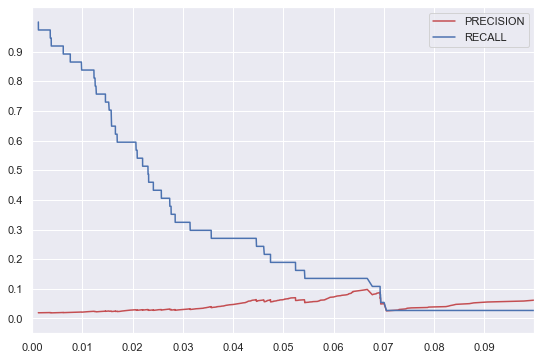

In [474]:
# Plot each precision,recall value for the thresholds 
plt.plot(thresholds, precision[:-1], c ='r', label ='PRECISION') 
plt.plot(thresholds, recall[:-1], c ='b', label ='RECALL') 
plt.legend() 
plt.xlim(0,0.1)
plt.xticks(np.arange(0,0.1,0.01))
plt.yticks(np.arange(0,1,0.1));

We want to have Recall at high, but not pay too much of a price on precision. the slope for precision is low while recall slope is high so we can potentially climb high on recall. i'd say we consider two points:
1. recall at around .6 before the 'shoulder', TH at about 0.02
1. recall at around .25 before the shoulder, where precision is relativly high, TH at about 0.045

In [480]:
display(pd.DataFrame([precision, recall, thresholds],index=['precision','recall','TH']).T\
.loc[lambda x: (x.recall>0.5)&(x.TH>=0.02)].sort_values(['TH','precision'],).head(5))

display(pd.DataFrame([precision, recall, thresholds],index=['precision','recall','TH']).T\
.loc[lambda x: (x.recall<0.3)&(x.TH<=0.045)].sort_values(['TH','precision'],ascending=False).head(5))

,precision,recall,TH
1094,0.028609,0.594595,0.020003
1095,0.028646,0.594595,0.020009
1096,0.028683,0.594595,0.020011
1097,0.028721,0.594595,0.020026
1098,0.028758,0.594595,0.020026


,precision,recall,TH
1696,0.060000,0.243243,0.044997
1695,0.059603,0.243243,0.044960
1694,0.059211,0.243243,0.044910
1693,0.058824,0.243243,0.044855
1692,0.058442,0.243243,0.044764


,count,mean,std,min,50%,75%,90%,95%,max
prob_of_t,1894.0,0.021592,0.018807,0.000245,0.016899,0.027262,0.041997,0.053849,0.252495


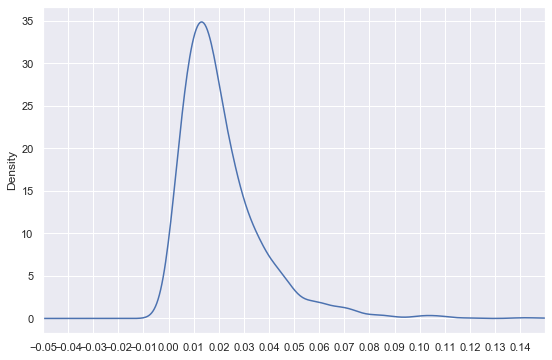

In [469]:
# lets see the distribution of the probabilities 
d.prob_of_t.plot(kind='kde',xticks=np.arange(-0.1, 0.15,0.01),xlim=(-0.05,0.15))
d.prob_of_t.describe(percentiles=[0.5,0.75,0.9,.95]).to_frame().T

**Treshold selection summary**
> - I think i'll go with **Threshold of 0.02**  for recall of ~60% and precision of ~3%
    - it's recall of 60% precision of 3% Vs recall of 25% Vs precision of 6%. losing a lot on recall in the 2nd option
- that coveres about 25% of the records which is very far from the 2% , but assuming the '1's are spreaded along this range of probabilities
- we'll have a high % of FP , but that's a price we're willing to pay to catch around half of the trues.

> if there's even a small chance of a claim we want the price to be high. or at least we want to know about it, and have the pricing algorithm consider it in the pricing (i.e weight by the predicted prob)

In [489]:
# selected model scores on validation set with the new TH 
TH= 0.02
new_pred= [1 if i >= TH else 0 for i in model.predict_proba(x_val_n_ohe)[:, 1]]

print("old recall value (default TH):", metrics.recall_score(y_val, ctb_y_pred.astype('bool'))) 
print("old precision value (default TH):", metrics.precision_score(y_val, ctb_y_pred.astype('bool')))
print("new recall value:", metrics.recall_score(y_val, new_pred)) 
print("new precision value:", metrics.precision_score(y_val, new_pred)) 

old recall value (default TH): 1.0
old precision value (default TH): 0.019535374868004225
new recall value: 0.5945945945945946
new precision value: 0.02860858257477243


### Final model Evaluation

In [490]:
# now we'll take the test set , and see the scores for the the models' prediction with the TH
x_test_n_ohe= x_test.drop(df_ohe.columns,axis=1).join(df_data[['product','state','card_type']])

test_TH_pred= [1 if i >= TH else 0 for i in model.predict_proba(x_test_n_ohe)[:, 1]]

In [491]:
print(f"""Recall: {round(metrics.recall_score(y_test, test_TH_pred)*100,1)}% (we expect the model to catch that many of the true labels) 
Precision: {round(metrics.precision_score(y_test, test_TH_pred)*100,1)}% (we expect the model to be right in his 'true' prediction in this percent of the cases)""") 


Recall: 53.8% (we expect the model to catch that many of the true labels) 
Precision: 3.1% (we expect the model to be right in his 'true' prediction in this percent of the cases)


In [492]:
res= (y_test.rename('is_claim')*1).to_frame().assign(claim_prob= model.predict_proba(x_test_n_ohe)[:, 1],
                                               claim_pred= test_TH_pred)

conf_mat= metrics.confusion_matrix(y_test,test_TH_pred) 
display(pd.DataFrame(conf_mat,index=['act_0','act_1'],columns=['pred_0','pred_1']))#[[TN,FP],[FN,TP]]

print(f"""We can see we catch half of the true labels ({conf_mat[1,1]} Vs {conf_mat[1,0]}), 
but we falsly alert {conf_mat[0,1]} cases (FPR: {round(conf_mat[0,1]/sum(conf_mat[0])*100,1)}%)""")

,pred_0,pred_1
act_0,699,437
act_1,12,14


We can see we catch half of the true labels (14 Vs 12), 
but we falsly alert 437 cases (FPR: 38.5%)


**Conclusion on model preformance:**
- we have about half of the true claims predicted. that's good if we indeed want to include that in the pricing. 
- we have a pretty high FalsePositive rate of almost 40%. that might be a bit too high. 40% of 'over prices' policies
- however, if the pricing goes by prob weight, with an exponential price increare by prob (activated by if prob>TH) then it might be ok

## Prep for prod

### Functions

In [456]:
def clean_values(input_row):
    """only for fire_housing_proximity"""
    val= input_row['fire_housing_proximity']
    if not val.isdigit():
        new_val= int(''.join(c for c in val if c.isdigit()))
        input_row['fire_housing_proximity']= new_val
    else:
        input_row['fire_housing_proximity']= int(val)
    
    return(input_row)

In [402]:
def complete_missing_values(input_row, col_to_complete=['portable_electronics','user_age','card_type'], age_fill=31):
    com_dict= {k:v for k,v in zip(['portable_electronics','user_age','card_type'],[0,age_fill,'unknown'])}
    for k,v in input_row.items():
        if v is np.nan:
            if k not in col_to_complete+['square_ft','coast']:
                print(f'Warning! non accounted for missing value for {k}')
            else:
                input_row[k]= com_dict[k] if k in col_to_complete else v
                
    return(input_row)

Train set didn't contain 'cosat states' with missing values. but i'll account for it here and calc the mean value

In [429]:
df_data.loc[df_data.is_coast_country==1].coast.isna().any()
state_coast_avg_dict= df_data.loc[df_data.is_coast_country==1].groupby('state').coast.mean().astype(int).to_dict()
state_coast_avg_dict

{'CA': 14,
 'CT': 13,
 'GA': 29,
 'IL': 17,
 'IN': 30,
 'MD': 28,
 'NJ': 10,
 'NY': 4,
 'OR': 30,
 'RI': 9,
 'TX': 29,
 'WI': 17}

In [504]:
def add_features(input_row):
    state_int_dict= {'CA': 0,'TX': 1,'NY': 2,'IL': 3,'NJ': 4,'GA': 5,'OH': 6,'NV': 7,'PA': 8,'AZ': 9,'MI': 10,'OR': 11,'MD': 12,'DC': 13,'WI': 14,'IA': 15,'NM': 16,'CT': 17,'RI': 18,'AR': 19,'IN': 20}
    coast_state_dict= {'AR': 0,'AZ': 0,'CA': 1,'CT': 1,'DC': 0,'GA': 1,'IA': 0,'IL': 1,'IN': 1,'MD': 1,'MI': 0,'NJ': 1,'NM': 0,'NV': 0,'NY': 1,'OH': 0,'OR': 1,'PA': 0,'RI': 1,'TX': 1,'WI': 1}
    state_coast_avg_dict= {'CA': 14,'CT': 13,'GA': 29,'IL': 17,'IN': 30,'MD': 28,'NJ': 10,'NY': 4,'OR': 30,'RI': 9,'TX': 29,'WI': 17}
    
    input_row['state_int']=state_int_dict[input_row['state']]
    input_row['is_coast_country']= coast_state_dict[input_row['state']]
    input_row['is_returning_user']= input_row['previous_policies']>1
                                          
    if (input_row['coast'] is np.nan) | (input_row['is_coast_country']==0):
        input_row['coast_f']= state_coast_avg_dict[input_row['state']] if input_row['is_coast_country']==1 else 999
    else:
        input_row['coast_f']= input_row['coast']

    return(input_row)

### edit script input row

In [641]:
some_row= pd.read_csv('lemonade_ds_coding_task_data_(2).csv').loc[77]
input_row= dict(some_row[:-1])
input_row

{'id': -4081407495940146535,
 'state': 'WI',
 'postal_code': 53207,
 'product': 'ho4',
 'user_id': -8985758467679922517,
 'square_ft': nan,
 'high_risk_dog': 0,
 'has_fire_alarm': True,
 'has_burglar_alarm': False,
 'portable_electronics': 1.0,
 'coast': 2.0,
 'fire_housing_proximity': '1',
 'previous_policies': 0,
 'user_age': 27.0,
 'card_type': 'debit'}

In [642]:
input_row_cln= clean_values(input_row)
input_row_f= complete_missing_values(input_row_cln)
input_row_full= add_features(input_row_f)
print(f'After:{input_row_full}')

After:{'id': -4081407495940146535, 'state': 'WI', 'postal_code': 53207, 'product': 'ho4', 'user_id': -8985758467679922517, 'square_ft': nan, 'high_risk_dog': 0, 'has_fire_alarm': True, 'has_burglar_alarm': False, 'portable_electronics': 1.0, 'coast': 2.0, 'fire_housing_proximity': 1, 'previous_policies': 0, 'user_age': 27.0, 'card_type': 'debit', 'state_int': 14, 'is_coast_country': 1, 'is_returning_user': False, 'coast_f': 2.0}


In [643]:
COLS_ORDER= ['state_int', 'postal_code', 'is_coast_country', 'coast_f',
       'high_risk_dog', 'has_fire_alarm', 'has_burglar_alarm',
       'fire_housing_proximity', 'portable_electronics', 'previous_policies',
       'user_age', 'is_returning_user', 'product', 'state', 'card_type']

new_input= {k:input_row_full[k] for k in COLS_ORDER}
new_input

{'state_int': 14,
 'postal_code': 53207,
 'is_coast_country': 1,
 'coast_f': 2.0,
 'high_risk_dog': 0,
 'has_fire_alarm': True,
 'has_burglar_alarm': False,
 'fire_housing_proximity': 1,
 'portable_electronics': 1.0,
 'previous_policies': 0,
 'user_age': 27.0,
 'is_returning_user': False,
 'product': 'ho4',
 'state': 'WI',
 'card_type': 'debit'}

In [644]:
model.predict_proba(list(new_input.values()))[1]#,  model.predict_proba(x_test_n_ohe.loc[29].to_frame().T)[:, 1]

0.2524949215520412

In [557]:
#save model object
filename = 'finalized_model'
pickle.dump(model, open(filename, 'wb'))

In [651]:
"""{'id': -4081407495940146535,
 'state': 'WI',
 'postal_code': 53207,
 'product': None,
 'user_id': -8985758467679922517,
 'square_ft': None,
 'high_risk_dog': 0,
 'has_fire_alarm': True,
 'has_burglar_alarm': False,
 'portable_electronics': 1.0,
 'coast': None,
 'fire_housing_proximity': '1',
 'previous_policies': 0,
 'user_age': 27.0,
 'card_type': 'debit'}""".replace("\n",'')

"{'id': -4081407495940146535, 'state': 'WI', 'postal_code': 53207, 'product': None, 'user_id': -8985758467679922517, 'square_ft': None, 'high_risk_dog': 0, 'has_fire_alarm': True, 'has_burglar_alarm': False, 'portable_electronics': 1.0, 'coast': None, 'fire_housing_proximity': '1', 'previous_policies': 0, 'user_age': 27.0, 'card_type': 'debit'}"